# ResNeXt from Scratch in PyTorch

ResNeXt stands for "Residual Networks Next" (https://arxiv.org/abs/1611.05431), indicating its position as an evolution of the ResNet architecture.

WIP

In [ ]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Define configs for different ResNeXt versions

In [ ]:
# resnext_= (num channels, repetition, cardinality, bottleneck_width)
model_hparameters= {}
model_hparameters['resnext50_32x4d'] = ([64,128,256,512], [3,4,6,3],  32, 4)
model_hparameters['resnext101_32x8d']= ([64,128,256,512], [3,4,23,3], 32, 8)
model_hparameters['resnext101_64x4d']= ([64,128,256,512], [3,4,23,3], 64, 4)
model_hparameters['resnext152_32x4d']= ([64,128,256,512], [3,8,36,3], 32, 4)
model_hparameters["resnext152_32x8d"]= ([64,128,256,512], [3,8,36,3], 32, 8)

# Architecture Implementation

In [ ]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    ResNeXt-style: Input -> Conv2d -> BatchNorm2d -> ReLU -> Output
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1,
                 bias=False, activation=None) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm= nn.BatchNorm2d(out_channels)
        # Activation function -- ReLU is the default in ResNeXt
        self.activation= activation


    def forward(self, x):
        x= self.conv(x)
        x= self.norm(x)
        if self.activation is not None:
            x= self.activation(x)

        return x


In [ ]:
class BottleneckBlock(nn.Module):
    """
    Creates a ResNeXt Bottleneck Block. It uses 1x1 convolution before the 3x3 module with
    grouped convolutions. The final 1x1 convolution restores the original dimensions.
    """

    def __init__(self, in_channels, out_channels, cardinality, base_width, expansion=4, stride=1,
                 activation=None, dropout=0.1) -> None:
        super(BottleneckBlock, self).__init__()
        # Activation function -- ReLU is the default in ResNeXt
        activation= nn.GELU() if activation is None else activation
        # Define dimensions for intermediate layers
        dim= int(out_channels * (base_width / 64)) * cardinality

        # For all ResNeXt-50+
        self.bottleneck= nn.Sequential(
            # Conv1x1 -> BN -> Activation (dimensionality reduction)
            ConvLayer(
                in_channels, dim, kernel_size=1, stride=1, padding=0, bias=False,
                activation=activation
            ),
            # Conv3x3 grouped convolution -> BN -> Activation (feature extraction)
            ConvLayer(
                dim, dim, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False,
                activation=activation
            ),
            # Conv1x1 -> BN (restoring dimensions)
            ConvLayer(
                dim, out_channels*expansion, kernel_size=1, stride=1, padding=0, bias=False,
                activation=None
            ),
        )
        # Dropout module for regularization
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None
        # When dim(x) == dim(F) -> Identity function
        if stride != 1 or in_channels != out_channels*expansion:
            # Only one conv -> BN and no activation (aka shortcut connection)
            self.downsample= ConvLayer(
                in_channels, out_channels*expansion, kernel_size=1, stride=stride, padding=0,
                bias=False, activation=None
            )
        else:
            self.downsample= None

        self.activation= activation


    def forward(self, x):
        identity= x

        out= self.bottleneck(x)
        if self.dropout is not None:
            out= self.dropout(out)
        if self.downsample is not None:
            identity= self.downsample(identity)
        # skip connection -- identity or projected map
        out += identity

        return self.activation(out)


# Building the ResNeXt

In [ ]:
class ResNeXt(nn.Module):
    """
    Implements a ResNeXt model.
    """

    def __init__(self, model_type, in_channels, num_classes, activation=None, dropout=0.1) -> None:
        super(ResNeXt, self).__init__()
        # block expansion factor (same value as ResNet-50+)
        expansion= 4
        # channels and repeatition lists along with group cardinality and bottleneck width
        channels=    model_type[0]
        repetitions= model_type[1]
        cardinality= model_type[2]
        base_width=  model_type[3]
        # Activation function -- ReLU is the default in ResNeXt
        activation= nn.GELU() if activation is None else activation

        # Initial convolution
        self.conv_in= nn.Sequential(
            ConvLayer(
                in_channels, out_channels=64, kernel_size=7, stride=2, padding=3,
                bias=False, activation=activation
            ),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.in_channels= 64
        # ResNeXt blocks
        self.block1= self.make_block(
            channels[0], repetitions[0], cardinality, base_width, expansion, stride=1,
            activation=activation, dropout=dropout
        )
        self.block2= self.make_block(
            channels[1], repetitions[1], cardinality, base_width, expansion, stride=2,
            activation=activation, dropout=dropout
        )
        self.block3= self.make_block(
            channels[2], repetitions[2], cardinality, base_width, expansion, stride=2,
            activation=activation, dropout=dropout
        )
        self.block4= self.make_block(
            channels[3], repetitions[3], cardinality, base_width, expansion, stride=2,
            activation=activation, dropout=dropout
        )

        # Pooling and classification head to produce the class logits
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc_out= nn.Linear(channels[3]*expansion, num_classes)

        # initialize parameters -- Xavier is suitable for GELU
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def make_block(self, out_channels, repetitions, cardinality, base_width, expansion,
                   stride, activation, dropout):
        """
        Create a ResNeXt block with multiple bottleneck blocks.
        """
        blocks= [BottleneckBlock(
            self.in_channels, out_channels, cardinality, base_width, expansion, stride,
            activation, dropout
        )]
        self.in_channels= out_channels*expansion

        for _ in range(1, repetitions):
            blocks.append(BottleneckBlock(
                self.in_channels, out_channels, cardinality, base_width, expansion, stride=1,
                activation=activation, dropout=dropout
            ))

        return nn.Sequential(*blocks)


    def forward(self, x):
        x= self.conv_in(x)
        x= self.block1(x)
        x= self.block2(x)
        x= self.block3(x)
        x= self.block4(x)
        x= torch.flatten(self.average_pool(x), start_dim=1)

        return self.fc_out(x)


In [ ]:
import torchvision.models as models
from torchvision.models import ResNeXt50_32X4D_Weights

img= torch.randn(1, 3, 224, 224).to(device)

tvis_model= models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)
print(tvis_model(img).shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 162MB/s]


Number of parameters: 25028904
torch.Size([1, 1000])


In [ ]:
model= ResNeXt(model_hparameters['resnext50_32x4d'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)
model

Number of parameters: 25028904
torch.Size([1, 1000])


ResNeXt(
  (conv_in): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): BottleneckBlock(
      (bottleneck): Sequential(
        (0): ConvLayer(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): GELU(approximate='none')
        )
        (1): ConvLayer(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): GELU(approximate='non

In [ ]:
from torchvision.models import ResNeXt101_32X8D_Weights

tvis_model= models.resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)
print(tvis_model(img).shape)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:01<00:00, 214MB/s]


Number of parameters: 88791336
torch.Size([1, 1000])


In [ ]:
model= ResNeXt(model_hparameters['resnext101_32x8d'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 88791336
torch.Size([1, 1000])


In [ ]:
from torchvision.models import ResNeXt101_64X4D_Weights

tvis_model= models.resnext101_64x4d(weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)
print(tvis_model(img).shape)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:01<00:00, 172MB/s]


Number of parameters: 83455272
torch.Size([1, 1000])


In [ ]:
model= ResNeXt(model_hparameters['resnext101_64x4d'], in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 83455272
torch.Size([1, 1000])


# Training a ResNeXt model from scratch

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 83.2MB/s]


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Early Stopping: based on validation loss to prevent overfitting.
- Play with different activation functions.
- Play with different learning rate values.

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- ResNeXt ---
in_channels= 3
num_classes= 10

model= ResNeXt(
    model_hparameters['resnext50_32x4d'], in_channels, num_classes, dropout=0.1
).to(device)

count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 23000394
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.6754 | Val Loss: 1.4763 | dt/epoch: 98667.81ms
Epoch: 1 | Train Loss: 1.0517 | Val Loss: 0.9628 | dt/epoch: 97813.50ms
Epoch: 2 | Train Loss: 0.7850 | Val Loss: 0.7932 | dt/epoch: 97531.24ms
Epoch: 3 | Train Loss: 0.6198 | Val Loss: 0.6656 | dt/epoch: 97818.35ms
Epoch: 4 | Train Loss: 0.4988 | Val Loss: 0.6113 | dt/epoch: 97603.17ms
Epoch: 5 | Train Loss: 0.4259 | Val Loss: 0.5686 | dt/epoch: 97839.90ms
Epoch: 6 | Train Loss: 0.3573 | Val Loss: 0.4243 | dt/epoch: 97803.33ms
Epoch: 7 | Train Loss: 0.3116 | Val Loss: 0.4346 | dt/epoch: 98082.04ms
Epoch: 8 | Train Loss: 0.2702 | Val Loss: 0.4676 | dt/epoch: 98260.43ms
Epoch: 9 | Train Loss: 0.2348 | Val Loss: 0.4056 | dt/epoch: 97817.59ms
Epoch: 10 | Train Loss: 0.2034 | Val Loss: 0.4682 | dt/epoch: 97590.69ms
Epoch: 11 | Train Loss: 0.1722 | Val Loss: 0.4837 | dt/epoch: 97759.53ms
Epoch: 12 | Train Loss: 0.1516 | Val Loss: 0.3956 | dt/epoch: 97520.16ms
Epoch: 13 | Train Loss: 0.1351 | Val Loss: 0.4828 | dt/epoch:

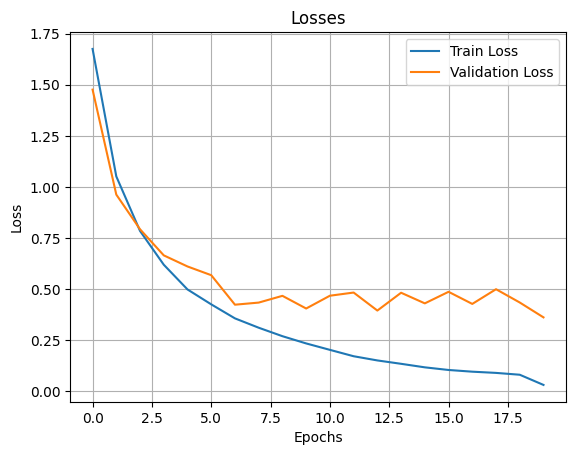

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
resnext_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 90.57%


In [ ]:
# https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# https://www.geeksforgeeks.org/resnext-architecture-in-computer-vision/
# https://towardsai.net/p/computer-vision/resnext-from-scratch
# https://medium.com/@atakanerdogan305/resnext-a-new-paradigm-in-image-processing-ee40425aea1f
# https://medium.com/the-modern-scientist/resnext-revolutionizing-deep-learning-with-wide-residual-networks-f403f843234b
# https://github.com/titu1994/Keras-ResNeXt